# Figure 1: mass distribution

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

def smoothing(H,sm):
    g = gf(H,sm)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(),g.shape)
    return c 

distribution = 'NOT fixed' #fixed or 'NOT fixed'
DCOtype='BHNS'
poptype='A'

if poptype == 'A':
    w_type='w_000'
    r0 = 149 #43
    w_type_high = 'w_000'
    r0_high = 302 #200
    w_type_low = 'w_000'
    r0_low = 62

Loading intrinsic population
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Uniform

Loading intrinsic population
Computing weights

EoS: DD2
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing weights

EoS: DD2
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Uniform



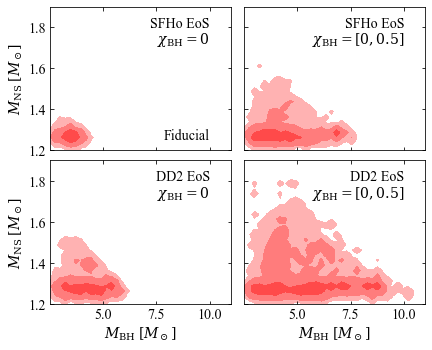

In [6]:
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=6,5
plt.rcParams['mathtext.fontset']='dejavuserif'
plt.rcParams['legend.handlelength'] = 0

gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(2,2,gridspec_kw=gs_kw)

num = 1000000
### --- Weights --- ###
spins = ['Zero','Uniform']
eos = ["SFHo","DD2"]

for k in range(len(eos)):
    mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS
    table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos[k]),'r')
    
    path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line!
    
    ### --- Loading Population --- ###
    
    print("Loading intrinsic population")
    mbh = table['mbh'][()]
    mns = table['mns'][()]
    spin_bh = table['spin_bh'][()]
    thv = table['thv'][()]
    z = table['z'][()]
    m_out = table['m_out'][()]
    
    table.close()
    
    np.random.seed(0)
    for i in range (len(spins)):
        spin_prescription = spins[i]
        spin = calculate_spin_olderCOMPASdata(data_path=path)
        if spin_prescription == 'Bavera21':
            spinM1, spinM2  = spin.Bavera21()
        if spin_prescription == 'Qin21':
            spinM1, spinM2  = spin.Qin21()
        if spin_prescription == 'Uniform':
            spinM1, spinM2  = spin.Bavera21()
            spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
            spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
        elif spin_prescription == 'Zero':
            spinM1, spinM2  = spin.Bavera21()
            spinM1 = np.random.uniform(0.,0.,spinM1.shape)
            spinM2 = np.random.uniform(0.,0.,spinM2.shape)
        
        bhx=[2.5,27]
        nsx=[1.1,3]
        spinx=[0.,1.]
        binsx=50
        binsy=50
        binsz=50
                  
        if distribution == 'fixed':
            C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)            
        
        if distribution == 'NOT fixed':
            C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
        
        print("")
        print("EoS:",eos[k])
        print("Population model:",poptype)
        print("The mass and spin distributions are", distribution)
        if distribution == 'fixed':
            print("The fiducial SFRD is", w_type, "with r0 =", r0)
            print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
            print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
        print("The spin prescription is:", spin_prescription)
        print("")
    
        cond = (m_out>0.)&(w>0.)
        
        bins=40
        H, xedges, yedges= np.histogram2d(mbh[cond],mns[cond],weights=w[cond],range=[[2.4,12],[1.1,2.1]],bins=bins)
        
        c = smoothing(H,0.5)
        
        xcentre = np.zeros(bins)
        ycentre = np.zeros(bins)
        
        for j in range(len(xedges)-1):
            xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
        
        for j in range(len(yedges)-1):
            ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
            
        X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
        
        ax[k,i].contourf(X,Y,c,levels=[0.01,1.],colors="red",alpha=.3)
        ax[k,i].contourf(X,Y,c,levels=[0.1,1.],colors="red",alpha=.3)
        ax[k,i].contourf(X,Y,c,levels=[0.5,1.],colors="red",alpha=.4)

        ax[k,i].set_xlim(2.505,11.)
        ax[k,i].set_ylim(1.2,1.9)
        ax[k,i].tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=14)
        if k == 0:
            if i == 0:
                ax[k,i].set_ylabel('$M_\mathrm{NS}$ $[M_\odot]$',size=14)
                ax[k,i].axes.xaxis.set_ticklabels([])
                ax[k,i].text(10,1.8, "SFHo EoS", ha='right', color="black",size=14.)
                ax[k,i].text(10,1.72, r"$\chi_\mathrm{BH} = 0$", ha='right', color="black",size=14.)
                ax[k,i].text(10,1.25, "Fiducial", ha='right', color="black",size=14.)
            if i == 1:
                ax[k,i].axes.yaxis.set_ticklabels([])
                ax[k,i].axes.xaxis.set_ticklabels([])
                ax[k,i].text(10,1.8, "SFHo EoS", ha='right', color="black",size=14.)
                ax[k,i].text(10,1.72, r"$\chi_\mathrm{BH} = [0, 0.5]$", ha='right', color="black",size=14.)
        if k == 1:
            if i == 0:
                ax[k,i].set_ylabel('$M_\mathrm{NS}$ $[M_\odot]$',size=14)
                ax[k,i].set_xlabel('$M_\mathrm{BH}$ $[M_\odot]$',size=14)
                ax[k,i].text(10,1.8, "DD2 EoS", ha='right', color="black",size=14.)
                ax[k,i].text(10,1.72, r"$\chi_\mathrm{BH} = 0$", ha='right', color="black",size=14.)
            if i == 1:
                ax[k,i].set_xlabel('$M_\mathrm{BH}$ $[M_\odot]$',size=14)
                ax[k,i].axes.yaxis.set_ticklabels([])
                ax[k,i].text(10,1.8, "DD2 EoS", ha='right', color="black",size=14.)
                ax[k,i].text(10,1.72, r"$\chi_\mathrm{BH} = [0, 0.5]$", ha='right', color="black",size=14.)
 
plt.subplots_adjust(hspace=0.07,top=0.95,right=0.97,left=0.1,wspace=0.07)
plt.show()